# **Sale Price Analysis Notebook**

## Objectives

* Data Exploration of missing data using ProfileReport
* Correlation and PPS analysis
* Visualising findings in plots that can be later used in a Streamlit app.

## Inputs

* outputs/datasets/collection/house_prices_records.csv 

## Outputs

* Generate plots to be used later in a Streamlit app. 

## Additional Comments

* CRISP-DM: *Data Understanding* 

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/PP5-heritage-housing/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/PP5-heritage-housing'

## Import Libraries

In [4]:
# import all necessary packages and libraries for the notebook
import pandas as pd
from ydata_profiling import ProfileReport
from feature_engine.encoding import OneHotEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
import ppscore as pps

# Data Exploration

## Load Collected Data

In [9]:
df_raw_path = "outputs/datasets/collection/house_prices_records.csv"
df = pd.read_csv(df_raw_path)
df.head(5)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


---

# Exploratory Data Analysis (EDA)

Check data type and create a list of the columns with missing data in order to generate pandas profile report.

In [ ]:
df.info()

In [ ]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

Generate panda profiling report. This will help us to get more familiar with the content of the dataset, check variable type and distribution, missing levels and how each variable may related to our target.

In [ ]:
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

#### Observations

* Data set of 24 colums: 20 numerical and 4 text;
* Nearly 10% of total data is missing: 9 variables have data missing;
* EnclosedPorch and WoodDeckSF have 90.7% and 89.4% missing values respectively.

---

# Correlation and PPS Analysis

Correlation analysis is performed to evaluate the strength and direction of the linear relationship between variables
The following code taken from CI Churnometer project is designed to visualise the correlation and Predictive Power Score (PPS) matrices of the dataframe.
Let's first examine both the Spearman and Pearson coefficients.

In [14]:
corr_spearman = df.corr(method='spearman')['SalePrice'].sort_values(key=abs, ascending=False)[1:]
corr_spearman

OverallQual      0.809829
GrLivArea        0.731310
YearBuilt        0.652682
GarageArea       0.649379
TotalBsmtSF      0.602725
GarageYrBlt      0.593788
1stFlrSF         0.575408
YearRemodAdd     0.571159
OpenPorchSF      0.477561
LotArea          0.456461
MasVnrArea       0.421309
LotFrontage      0.409076
BsmtFinSF1       0.301871
2ndFlrSF         0.298809
WoodDeckSF       0.252176
BedroomAbvGr     0.229527
EnclosedPorch   -0.215010
BsmtUnfSF        0.185197
OverallCond     -0.129325
Name: SalePrice, dtype: float64

In [15]:
corr_pearson = df.corr(method='pearson')['SalePrice'].sort_values(key=abs, ascending=False)[1:]
corr_pearson

OverallQual      0.790982
GrLivArea        0.708624
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
BsmtFinSF1       0.386420
LotFrontage      0.351799
2ndFlrSF         0.322335
OpenPorchSF      0.315856
LotArea          0.263843
WoodDeckSF       0.252027
BsmtUnfSF        0.214479
EnclosedPorch   -0.176458
BedroomAbvGr     0.161901
OverallCond     -0.077856
Name: SalePrice, dtype: float64

In [21]:
top_n = 5
set(corr_pearson[:top_n].index.to_list() + corr_spearman[:top_n].index.to_list())

{'1stFlrSF',
 'GarageArea',
 'GrLivArea',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt'}

The most correlated variables (correlation of 0.6 or more) considering both spearman and pearson correlations are:  
'1stFlrSF', 'GarageArea', 'GrLivArea', 'OverallQual', 'TotalBsmtSF', and 'YearBuilt'.


Next, we will calculate the correlations, create heatmaps and display them.
Each heatmap will be saved in the directory for later use in the documentation of this project.

In [22]:
def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

Calculate the Correlations and Power Predictive Score.

In [23]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspa

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.066  0.702


Display Heatmaps



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



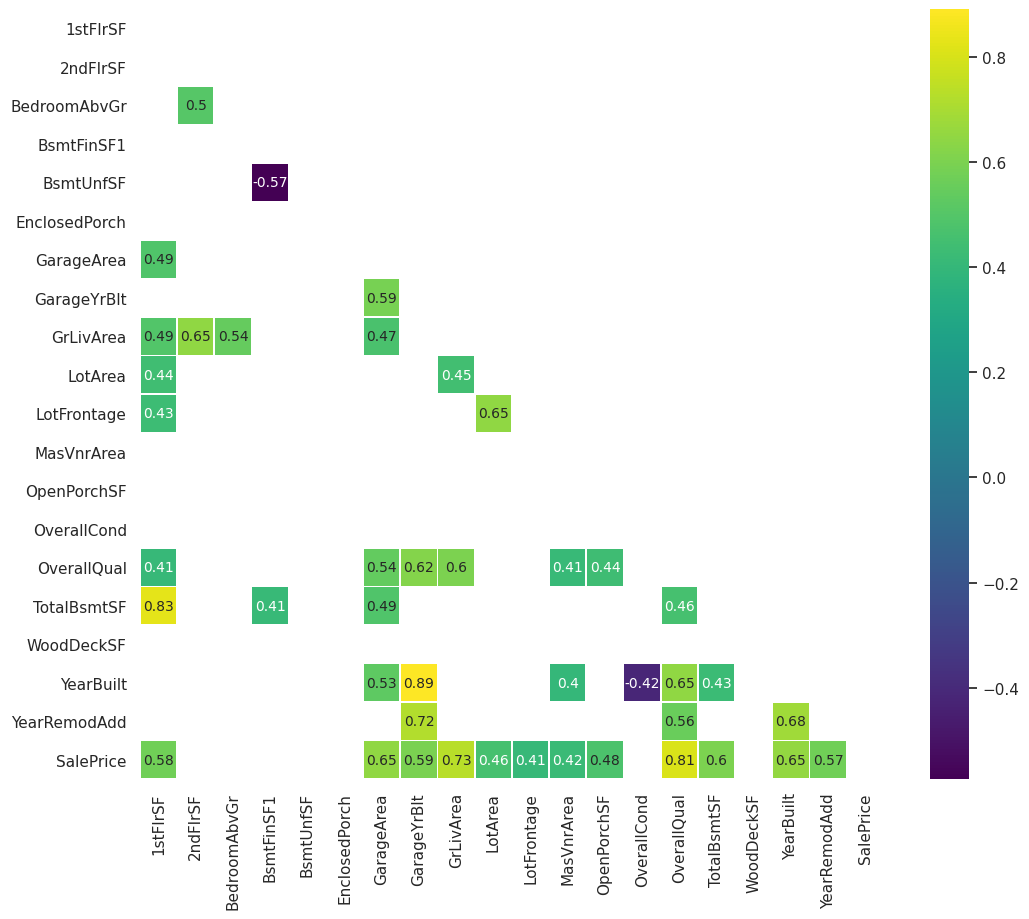



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



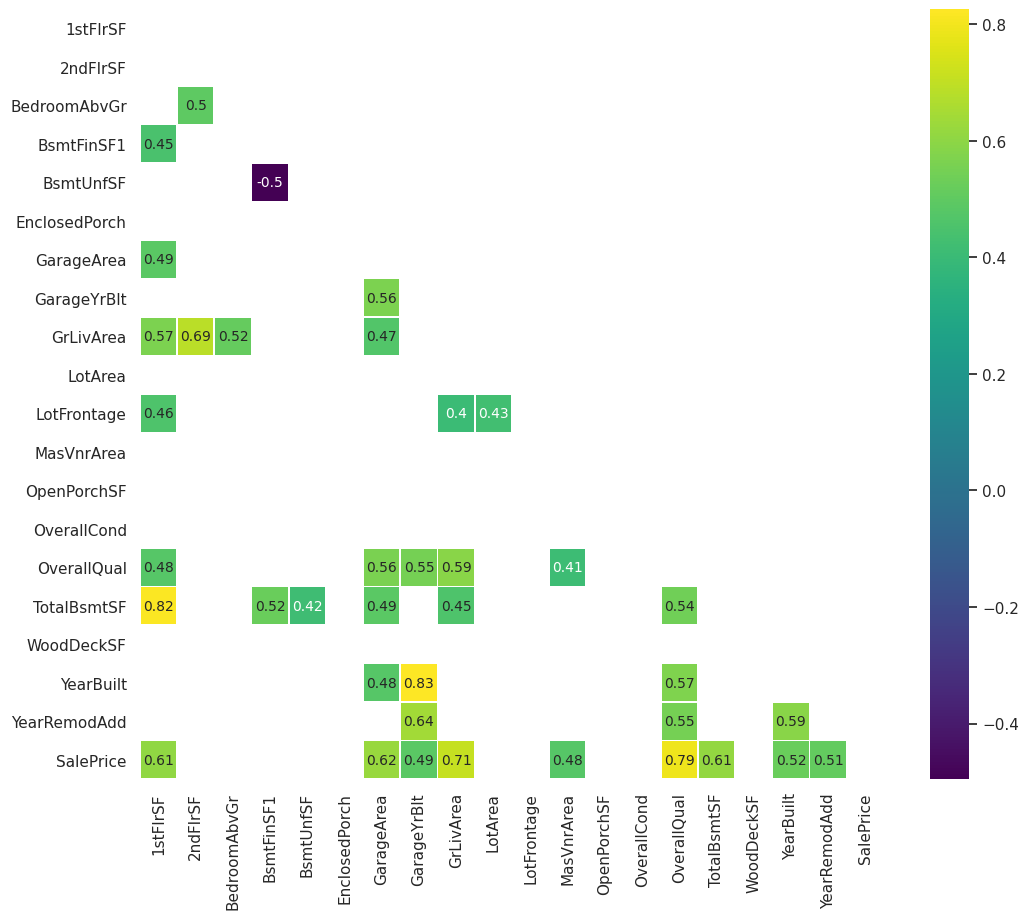



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



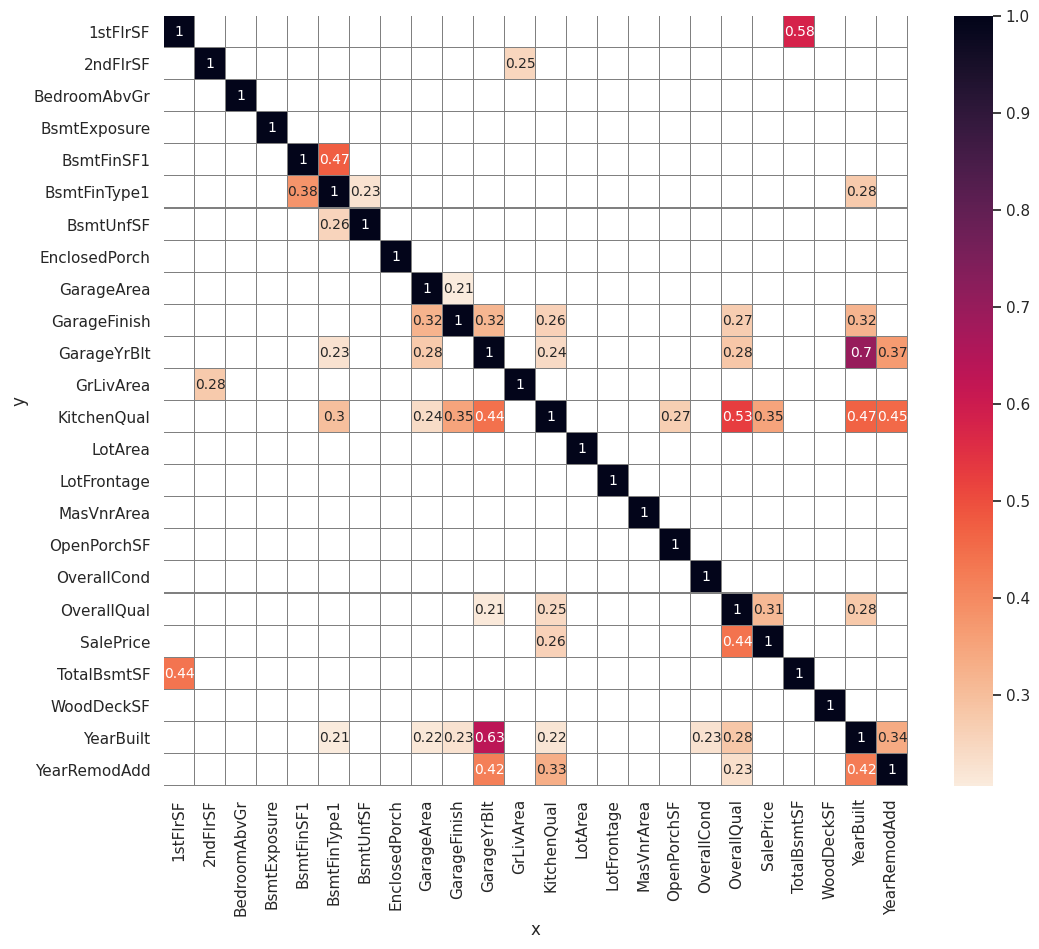

In [18]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.4, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

Considering the business requirement of seeing which property features most greatly influence its sale price, and after reviewing these visualisations with regard to the SalePrice variable we have the following observations:

* top 5 correlated to SalePrice are: 'GarageArea', 'GrLivArea', 'OverallQual', 'TotalBsmtSF', and 'YearBuilt'.

* 



Based on this exploration, let's consider OverallQual, GrLivArea, GarageArea, YearBuilt, 1stFlrSF, TotalBsmtSF as the most influential variables with regard to SalePrice to be studied.

In [26]:
vars_to_study = ['1stFlrSF', 'GarageArea', 'GrLivArea', 'OverallQual', 'TotalBsmtSF', 'YearBuilt']
vars_to_study

['1stFlrSF',
 'GarageArea',
 'GrLivArea',
 'OverallQual',
 'TotalBsmtSF',
 'YearBuilt']

# EDA on selected variables

In [27]:
df_eda = df.filter(vars_to_study + ['SalePrice'])
df_eda.head(3)

,1stFlrSF,GarageArea,GrLivArea,OverallQual,TotalBsmtSF,YearBuilt,SalePrice
0,856,548,1710,7,856,2003,208500
1,1262,460,1262,6,1262,1976,181500
2,920,608,1786,7,920,2001,223500


Plot each variable as a scatter plot against the sale price.

---

# Data Cleaning

### Assessing Missing Data Levels

NOTE

* You may add as many sections as you want, as long as they support your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* If you do not need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
